In [ ]:
from sklearn.preprocessing import StandardScaler
from functools import reduce
import pandas as pd
import config as cfg
import numpy as np
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# Load Feature Engineer Data

In [12]:
df = pd.read_csv(cfg.USER_FEATURES_ENG_DATA_PTH)

Epoch 1, Train Loss: 0.3833, Val Loss: 0.2383
Epoch 2, Train Loss: 0.2698, Val Loss: 0.2069
Epoch 3, Train Loss: 0.2434, Val Loss: 0.1920
Epoch 4, Train Loss: 0.2337, Val Loss: 0.1853
Epoch 5, Train Loss: 0.2270, Val Loss: 0.1816
Epoch 6, Train Loss: 0.2237, Val Loss: 0.1803
Epoch 7, Train Loss: 0.2193, Val Loss: 0.1792
Epoch 8, Train Loss: 0.2179, Val Loss: 0.1744
Epoch 9, Train Loss: 0.2152, Val Loss: 0.1729
Epoch 10, Train Loss: 0.2122, Val Loss: 0.1684
Epoch 11, Train Loss: 0.2116, Val Loss: 0.1673
Epoch 12, Train Loss: 0.2099, Val Loss: 0.1668
Epoch 13, Train Loss: 0.2088, Val Loss: 0.1590
Epoch 14, Train Loss: 0.2081, Val Loss: 0.1607
Epoch 15, Train Loss: 0.2075, Val Loss: 0.1574
Epoch 16, Train Loss: 0.2058, Val Loss: 0.1630
Epoch 17, Train Loss: 0.2059, Val Loss: 0.1614
Epoch 18, Train Loss: 0.2047, Val Loss: 0.1587
Epoch 19, Train Loss: 0.2049, Val Loss: 0.1596
Epoch 20, Train Loss: 0.2037, Val Loss: 0.1577
Early stopping triggered.
Number of outliers detected: 1300


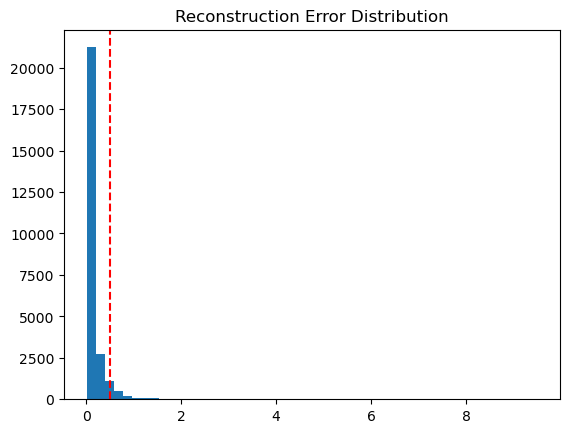

In [13]:

X = df[cfg.USER_FEATURES].fillna(0).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add Gaussian noise for denoising autoencoder
noise_factor = 0.1
X_noisy = X_scaled + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_scaled.shape)
X_noisy = np.clip(X_noisy, -3., 3.)

X_train, X_val, X_train_noisy, X_val_noisy = train_test_split(
    X_scaled, X_noisy, test_size=0.2, random_state=42
)

X_train_tensor = torch.tensor(X_train_noisy, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_noisy, dtype=torch.float32)
X_train_target_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_target_tensor = torch.tensor(X_val, dtype=torch.float32)

# 2. Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 8),
            nn.BatchNorm1d(8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

# 3. Train with early stopping
def train_autoencoder(model, X_train, X_val, y_train, y_val, n_epochs=100, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.L1Loss()
    train_loader = torch.utils.data.DataLoader(
        list(zip(X_train, y_train)), batch_size=128, shuffle=True
    )

    best_model = None
    best_val_loss = float('inf')
    wait = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for noisy_batch, clean_batch in train_loader:
            optimizer.zero_grad()
            output = model(noisy_batch)
            loss = criterion(output, clean_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(noisy_batch)

        avg_train_loss = train_loss / len(X_train)

        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val).item()

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model

# 4. Train model
input_dim = X_train.shape[1]
model = Autoencoder(input_dim)
model = train_autoencoder(model, X_train_tensor, X_val_tensor,
                          X_train_target_tensor, X_val_target_tensor)

# 5. Inference on full data
model.eval()
X_all_tensor = torch.tensor(X_scaled, dtype=torch.float32)
with torch.no_grad():
    X_recon = model(X_all_tensor)
    recon_errors = torch.mean(torch.abs(X_all_tensor - X_recon), dim=1).numpy()


threshold = np.percentile(recon_errors, 95)
outliers = recon_errors > threshold

print(f"Number of outliers detected: {outliers.sum()}")

plt.hist(recon_errors, bins=50)
plt.axvline(threshold, color='red', linestyle='--')
plt.title("Reconstruction Error Distribution")
plt.show()


In [14]:
thresholds = []
for r in recon_errors:
    if r > np.percentile(recon_errors, 95):
        thresholds.append(-1)
    else:
        thresholds.append(1)

In [15]:
df['anomaly_score_AE'] = recon_errors
df['anomaly_AE'] = thresholds

In [16]:
df.to_csv(cfg.AUTOENCODER_ISOLATION_FOREST_PTH, index=False)